In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings

def warn(*args, **kwargs):
    pass

warnings.warn = warn

As a first step we are going to fetch the needed data:

In [3]:
# read data
salinas = sio.loadmat('data/Salinas_cube.mat')
HSI = salinas['salinas_cube'] # image: 220x120x204

salinas_endm = sio.loadmat('data/Salinas_endmembers.mat')
endmembers = salinas_endm['salinas_endmembers'] # endmembers: 204x7

salinas_gt = sio.loadmat("data/Salinas_gt.mat")
labels = salinas_gt["salinas_gt"] # label: 204x7

class_names = {0: 'None', 1: 'Grapes', 2: 'Broccoli', 3: 'Fallow 1', 4: 'Fallow 2', 5: 'Fallow 3', 6: 'Stubble', 7: 'Celery'}

## Part 1 | Spectral Unmixing
---

### A. Unconstrainted Least Squares

Following the linear spectral unmixing hypothesis, we will use:

$$ y = Xθ + n \Leftrightarrow \hat θ = (X^TX)^{-1}X^Ty $$

In [4]:
X = endmembers
y = HSI[labels != 0].T # non-zero labels

# compute theta
theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
theta.shape # abundance map

(7, 16929)

In [5]:
# compute MSE for every pixel
reconstruction = y - np.dot(X, theta)
errors = np.trace(np.dot(reconstruction.T, reconstruction)) / 16929

print('Reconstruction error: {}'.format(round(errors, 2)))

Reconstruction error: 35058.88


### B. Least Squares imposing sum-to-one constraint

By imposing the sum-to-one constraint, the formulation of the problem becomes:

$$ y = Xθ + n \text{ subject to } \sum_{i=1}^Nθ_i=1 \Leftrightarrow θ_1 + θ_2 + θ_3 + θ_4 + θ_5 + θ_6 + θ_7 = 1 $$

The equation now is:

$$ y - x_7 = θ_1(x_1 - x_7) + θ_2(x_2 - x_7) + θ_3(x_3 - x_7) + θ_4(x_4 - x_7) + θ_5(x_5 - x_7) + θ_6(x_6 - x_7) \Leftrightarrow y'=X'Θ' + η $$

In [6]:
# compute new x-values through the substractions
X_sto = endmembers[:, :-1] - endmembers[:, -1:] 

# compute new y-values | # https://bit.ly/3juOQG8
y_sto = (y.T - endmembers[:, -1]).T

# compute theta
theta_sto = np.dot(np.dot(np.linalg.inv(np.dot(X_sto.T, X_sto)), X_sto.T), y_sto)
theta_sto.shape # abundance map, 6 since have new thetas

(6, 16929)

In [7]:
# compute MSE for every pixel
reconstruction_sto = y_sto - np.dot(X_sto, theta_sto)
errors_sto = np.trace(np.dot(reconstruction_sto.T, reconstruction_sto)) / 16929

print('Reconstruction error: {}'.format(round(errors_sto, 2)))

Reconstruction error: 43082.58


### C. Least Squares imposing non-negativity constraint 

Imposing the non-negativity constraint we get the following problem formulation:

$$ y = Xθ \text{ subject to } θ_i >= 0 \text{ } \forall i $$

In [8]:
# initialize linear regression with positivity constraint
nnls = LinearRegression(positive=True)

# compute theta
theta_nn = nnls.fit(X, y).coef_.T
theta_nn.shape # abundance map

(7, 16929)

In [9]:
reconstruction_nn = y - np.dot(X, theta_nn)
errors_nn = np.trace(np.dot(reconstruction_nn.T, reconstruction_nn)) / 16929

print('Reconstruction error: {}'.format(round(errors_nn, 2)))

Reconstruction error: 194728.94


### D. Least Squares imposing sum-to-one and non-negativity contraint

Combining methods *B* and *C* we formulate the problem as follows:

$$ y = Xθ \text{ subject to } θ_i >= 0 \text{ } \forall i \text{ and } \sum_{i=1}^Nθ_i=1 $$

In [10]:
# compute theta
theta_sto_nn = nnls.fit(X_sto, y_sto).coef_.T
theta_sto_nn.shape # abundance map

(6, 16929)

In [11]:
reconstruction_sto_nn = y - np.dot(X_sto, theta_sto_nn)
errors_sto_nn = np.trace(np.dot(reconstruction_sto_nn.T, reconstruction_sto_nn)) / 16929

print('Reconstruction error: {}'.format(round(errors_sto_nn, 2)))

Reconstruction error: 373768488.94


### E. LASSO

The problem formulates as follows: 

$$ y = Xθ +λ\sum_{i=1}^N||θ_i||_1 $$

In [12]:
lasso = Lasso(alpha=0.01, fit_intercept=False)

# compute theta
theta_lss = lasso.fit(X, y).coef_.T
theta_lss.shape # abundance map

(7, 16929)

In [13]:
reconstruction_lss = y - np.dot(X, theta_lss)
errors_lss = np.trace(np.dot(reconstruction_lss.T, reconstruction_lss)) / 16929

print('Reconstruction error: {}'.format(round(errors_lss, 2)))

Reconstruction error: 83217.45


### Part 1 Summary

We tried solving the problem at hand through unconstrained and constrained approaches. The reason why the latter methods were tested is due to that fact that constraint estimators can achieve better performance, by intoducing bias into the estimator aiming at potentially minimizing its variance. Unfortunately, that was not the case with our problem.

We notice that the unconstrained least squares approach achieves the lowest reconstruction error. If we were to rank the methods tested we would have:

1. Unconstrained Least Squares
2. Least Squares imposing sum-to-one constraint
3. LASSO regression
4. Least Squares imposing non-negativity constraint
5. Least Squares imposing sum-to-one and non-negativity constraints

## Part 2 | Classification
---
We move on to the calssification task:

In [14]:
# read data
salinas_labels = sio.loadmat('data/classification_labels_Salinas.mat')
training_set = (np.reshape(salinas_labels['training_set'], (120, 220))).T
test_set = (np.reshape(salinas_labels['test_set'], (120, 220))).T
operational_set = (np.reshape(salinas_labels['operational_set'], (120, 220))).T

# initialize training split
X_train = HSI[training_set > 0]
y_train = training_set[training_set > 0]
y_train = y_train.reshape(y_train.shape[0], 1) # convert to 2d, needed for the algos

# initialize test split
X_test = HSI[test_set > 0]
y_test = test_set[test_set > 0]
y_test = y_test.reshape(y_test.shape[0], 1)

# initialize 10-fold cross validation
kfold = model_selection.KFold(n_splits=10)

### A. Naive Bayes Classifier

In [15]:
# initialize classifier
naiveb = GaussianNB()
naiveb_valScore = model_selection.cross_val_score(naiveb, X_train, y_train, cv=kfold)

std_devt = round(naiveb_valScore.std()*100, 2)
error = round(100 - naiveb_valScore.mean()*100, 2)

print("Cross-validation \n\t mean error: {}% \n\t mean standard deviation: {}".format(error, std_devt))

Cross-validation 
	 mean error: 3.23% 
	 mean standard deviation: 4.99


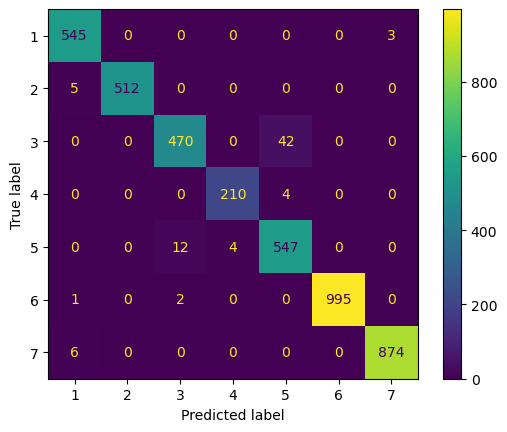

In [16]:
# predict on test
naiveb.fit(X_train, y_train)
y_pred = naiveb.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=[i for i in range(1, 8)])
cm_display.plot()
plt.show()

In [17]:
success_rate = np.trace(confusion_matrix) / np.sum(confusion_matrix)
print('Success rate: {}%'.format(round(success_rate * 100, 2)))

Success rate: 98.13%


### B. Minimum Distance Classifier

In [18]:
# https://bit.ly/3vcd62b
class MDC():
    def __init__(self):
        self.class_list = {}
        self.centroids = {}
    
    def fit(self, X, y):
        self.class_list = np.unique(y, axis=0)
        
        self.centroids = np.zeros((len(self.class_list), X.shape[1])) # each row is a centroid
        for i in range(len(self.class_list)): # for each class, we evaluate its centroid
            temp = np.where(y==self.class_list[i])[0]
            self.centroids[i,:] = np.mean(X[temp],axis=0)
            
            
    def predict(self, X):
        temp = np.argmin(
            cdist(X, self.centroids), # distance between each pair of the two collections of inputs
            axis=1
        )
        y_pred = np.array([self.class_list[i] for i in temp])

        return y_pred

In [19]:
# cross-validation
acc = []
for train_index, validation_index in kfold.split(X_train, y_train):
    X_train_curr, y_train_curr = X_train[train_index, :], y_train[train_index]
    X_validation_curr, y_validation_curr = X_train[validation_index, :], y_train[validation_index]
    
    mdc = MDC()
    mdc.fit(X_train_curr, y_train_curr)
    y_pred_curr = mdc.predict(X_validation_curr)
    
    confusion_matrix = metrics.confusion_matrix(y_validation_curr, y_pred_curr)
    err = (1 - np.trace(confusion_matrix) / np.sum(confusion_matrix)) * 100
    acc.append(err)

print("Cross-validation \n\t mean error: {}% \n\t mean standard deviation: {}".format(round(sum(acc)/10, 2), round(np.std(acc), 2)))

Cross-validation 
	 mean error: 5.51% 
	 mean standard deviation: 7.68


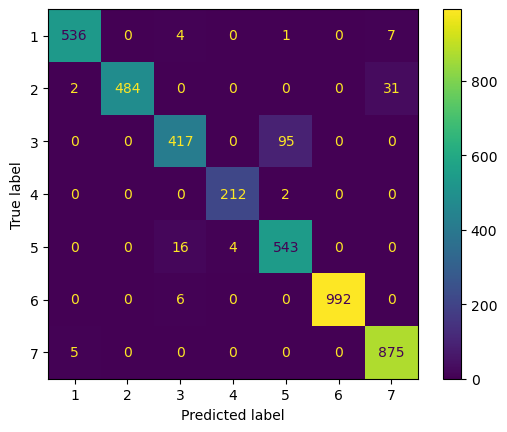

In [20]:
# predict on test
mdc = MDC()

mdc.fit(X_train, y_train)
y_pred = mdc.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=[i for i in range(1, 8)])
cm_display.plot()
plt.show()

In [21]:
success_rate = np.trace(confusion_matrix) / np.sum(confusion_matrix)
print('Success rate: {}%'.format(round(success_rate * 100, 2)))

Success rate: 95.91%


### C. K-nearest Neighbors Classifier

In [22]:
# initialize calssifier
kneighb = KNeighborsClassifier(n_neighbors=10)
kneighb_valScore = model_selection.cross_val_score(kneighb, X_train, y_train, cv=kfold)

std_devt = round(kneighb_valScore.std()*100, 2)
error = round(100 - kneighb_valScore.mean()*100, 2)

print("Cross-validation \n\t mean error: {}% \n\t mean standard deviation: {}".format(error, std_devt))

Cross-validation 
	 mean error: 2.0% 
	 mean standard deviation: 2.85


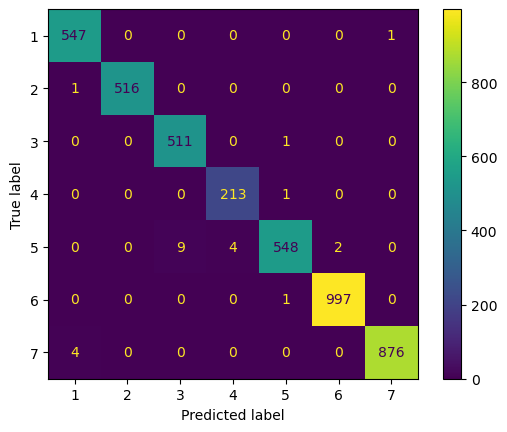

In [23]:
# predict on test
kneighb.fit(X_train, y_train)
y_pred = kneighb.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=[i for i in range(1, 8)])
cm_display.plot()
plt.show()

In [24]:
success_rate = np.trace(confusion_matrix) / np.sum(confusion_matrix)
print('Success rate: {}%'.format(round(success_rate * 100, 2)))

Success rate: 99.43%


### E. Random Forests (out of scope)

In [25]:
# initialize calssifier
rf = RandomForestClassifier()
rf_valScore = model_selection.cross_val_score(rf, X_train, y_train.ravel(), cv=kfold)

std_dev = round(rf_valScore.std()*100, 2)
error = round(100 - rf_valScore.mean()*100, 2)

print("Cross-validation \n\t mean error: {}% \n\t mean standard deviation: {}".format(error, std_devt))

Cross-validation 
	 mean error: 0.89% 
	 mean standard deviation: 2.85


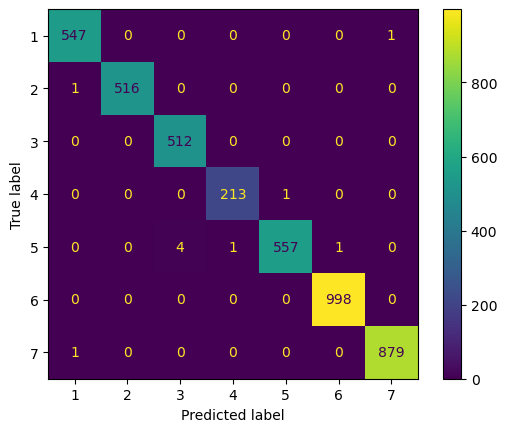

In [26]:
# predict on test
rf.fit(X_train, y_train.ravel())
y_pred = rf.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=[i for i in range(1, 8)])
cm_display.plot()
plt.show()

In [27]:
success_rate = np.trace(confusion_matrix) / np.sum(confusion_matrix)
print('Success rate: {}%'.format(round(success_rate * 100, 2)))

Success rate: 99.76%


### Part 2 Summary

The ranking of the classifiers that were tested has the following order:

1. Random Forests
2. K-nearest neighbors
3. Naive Bayes
4. Minimum distance classifier

We can clearly state that the performance of the classifiers is outstanding in the current dataset. We notice in all four confusion matrices a clear diagonal line, meaning that they classify the majority of data instances in their true class.

## Part 3 | Combination
---

Comparing the tasks of spectral unmixing and image classification, we can reach the conclusion that the latter is superior in annotating a data instance with the correct class. The becomes apparent if we compare the reconstruction error and success rate from the first and second approaches, respectively. The meaning behind this behaviour could be that the spectral information alone is not enough to distinguish points from different classes. However, we note that our dataset consists of similar-like classes, making their visual, at least, distinguishment far from obvious. Hence, in a different dataset with vastly different class types, i.e., water and mountain, the spectral information could prove worth looking into.